### Hypothesis -1

model list:
- dense_timed_simplest (baseline)
- dense_timed_simplest with lower amount of weights
- dense_autoencoder
- dense_timed_simplest_dilated with separate axes
- dense_timed_simplest_dilated with common axes
- convolutional autoencoder

Keras optimizers for 0.001, 0.0001, 0.00001
9000 recordings
prepare the gsm.wavs
tanh on dense initial and LeakyReLU on other convolutional - 6 first experiments
all leaky_relu = 6 next experiments
mean not removed, divided by STD, range from 0 to one digit number
if in 8 epochs the model doesnt improve == it has converged in that stage

##### Imports and initialization

In [2]:
%matplotlib inline

import os,sys
#path = os.path.realpath(os.path.join(os.getcwd(), ".."))
path = "/home/zantyr/Denoising"
sys.path.append(path)
os.chdir(path)

import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.io.wavfile as sio
import tempfile

from IPython.display import Image, Audio, display

import keras
from keras.utils.vis_utils import plot_model
from keras.layers         import Dropout, Input, Conv1D, Conv2D, AveragePooling2D, Flatten, Dense, Deconv2D, UpSampling2D, concatenate, BatchNormalization, Lambda, LeakyReLU, TimeDistributed, Reshape, LSTM, GaussianNoise
from keras.models         import Model
from keras.datasets.mnist import load_data
from keras.utils          import to_categorical
from keras.initializers   import Orthogonal
from keras.regularizers   import L1L2, l2
from keras.callbacks      import Callback
import keras.backend as K
import tensorflow as tf

import loaders
from loaders.transform import AddGaussianNoise, Windowing, GSMize, MixReverb, MixNoise, ConstantQTransform, Transcript, LengthOfWindow, Length, Lengthen, Null, DivisiblePad
from loaders.dataset import Dataset, enable_multiprocessing, disable_multiprocessing
from loaders.feature import NormalizedLogPowerRFFT, Trim
from loaders.experiment import SingleExperiment
from loaders.measures import MSE
from loaders.schedule import Schedule
from loaders.estimator import DefaultVisualizeTransform, Estimator
from loaders.extras import LossHistory, set_device, delog_griffin_lim, get_stft
from loaders.custom import identity_loss
set_device()               # switches to CPU if GPU busy
enable_multiprocessing()   # for faster preprocessing of data (multicore)

Using TensorFlow backend.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Switching to CPU only as GPU is busy or unavailable


##### Model definition

In [2]:
model_callbacks = []

Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, 129, 32 320         lambda_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, None, 129, 32 0           conv2d_1[0][0]                   
____________________________________

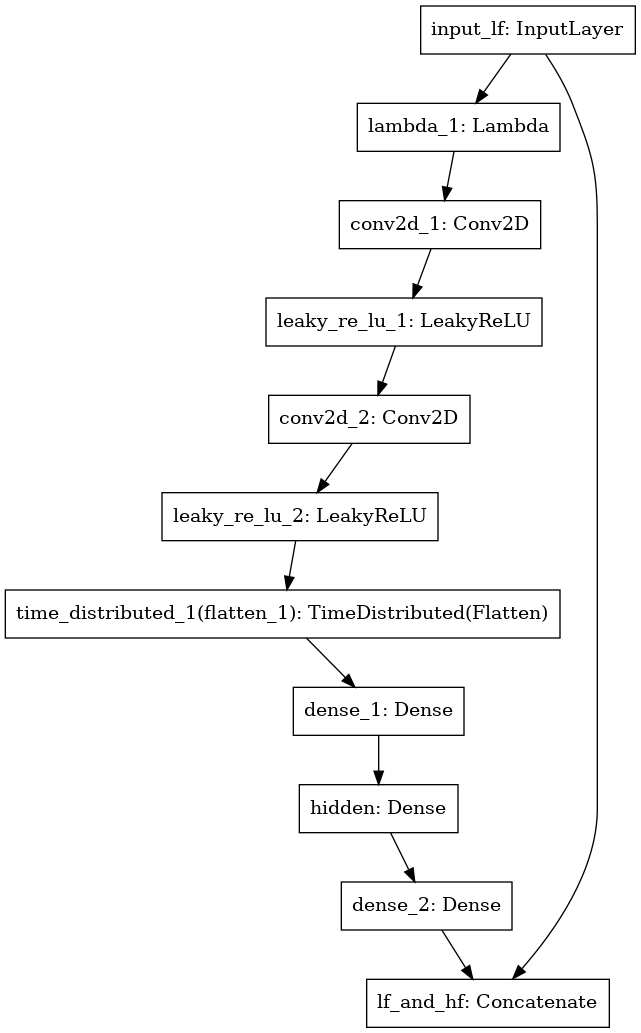

In [3]:
def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(32, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = Dense(2048, activation='tanh')(layer)
    layer = Dense(2048, activation='tanh', name='hidden')(layer)
    layer = Dense(128, activation='linear')(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, None, 129, 8) 80          lambda_2[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_3 (LeakyReLU)       (None, None, 129, 8) 0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

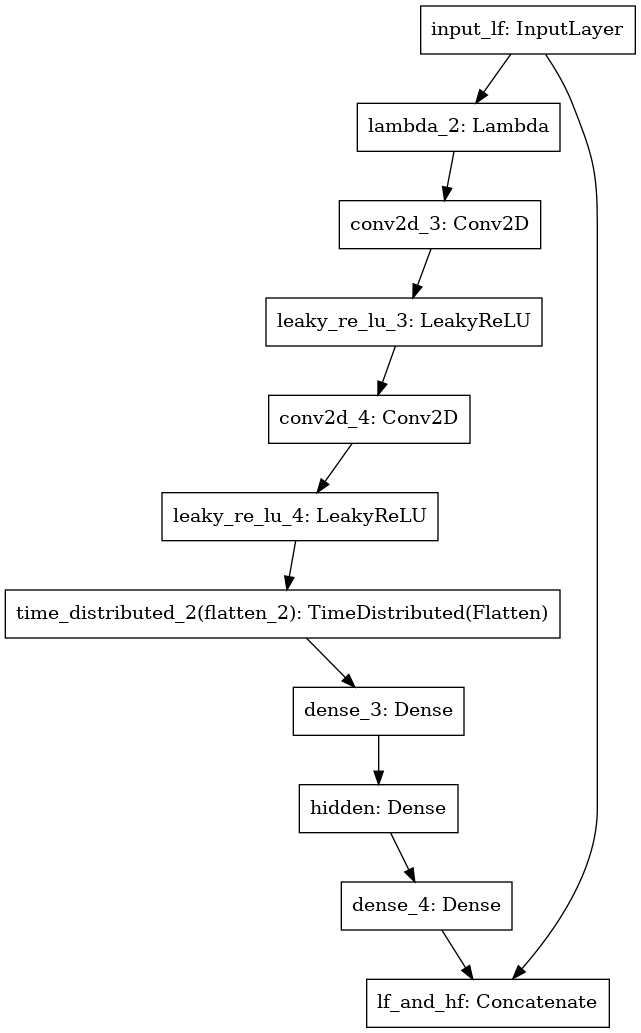

In [4]:
def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(8, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(8, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = Dense(512, activation='tanh')(layer)
    layer = Dense(512, activation='tanh', name='hidden')(layer)
    layer = Dense(128, activation='linear')(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, None, 129, 16 160         lambda_3[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, None, 129, 16 0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (

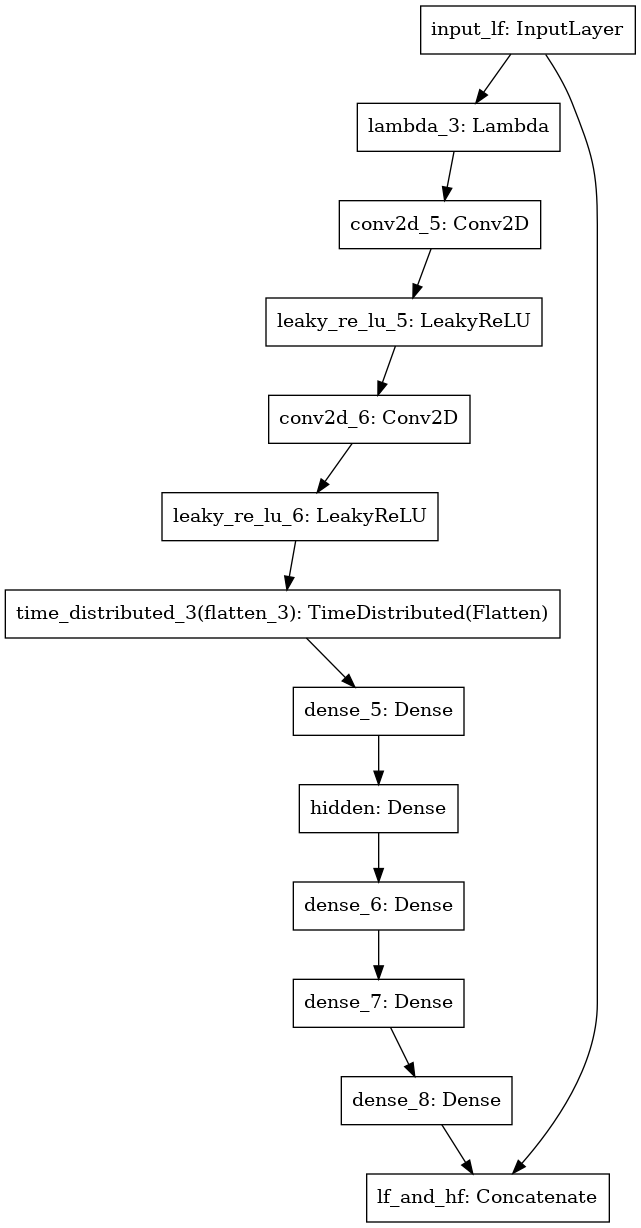

In [5]:
def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = Dense(512, activation='tanh')(layer)
    layer = Dense(96, activation='tanh', name='hidden')(layer)
    layer = Dense(512, activation='tanh')(layer)
    layer = Dense(2048, activation='tanh')(layer)
    layer = Dense(128)(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, None, 129, 16 160         lambda_4[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, None, 129, 16 0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (

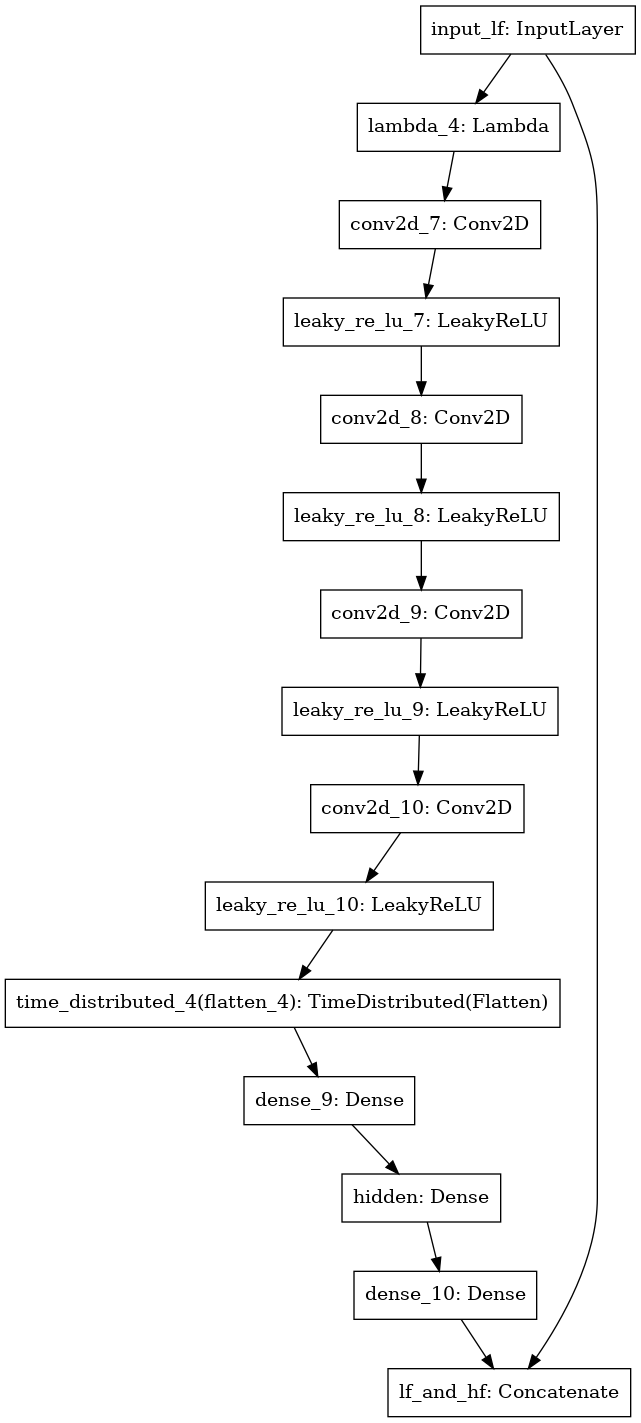

In [6]:
def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = Dense(1024, activation='tanh')(layer)
    layer = Dense(512, activation='tanh', name='hidden')(layer)
    layer = Dense(128)(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, None, 129, 32 1472        lambda_5[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_11 (LeakyReLU)      (None, None, 129, 32 0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 

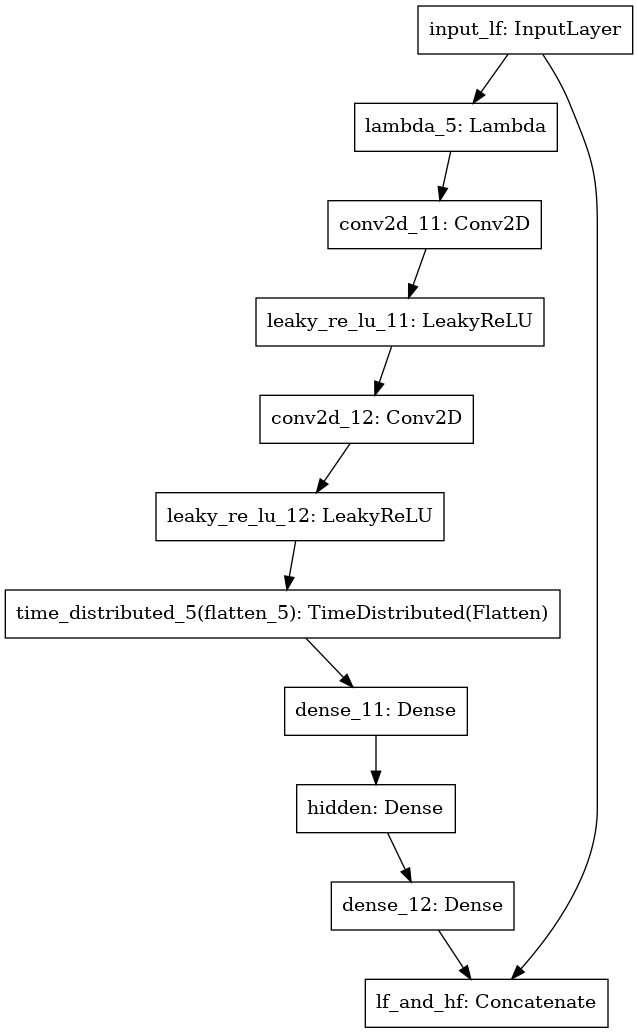

In [7]:
def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(32, kernel_size=(9,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(40, kernel_size=(9,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = Dense(1024, activation='tanh')(layer)
    layer = Dense(512, activation='tanh', name='hidden')(layer)
    layer = Dense(128)(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, None, 129, 16 160         lambda_6[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_13 (LeakyReLU)      (None, None, 129, 16 0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_14 

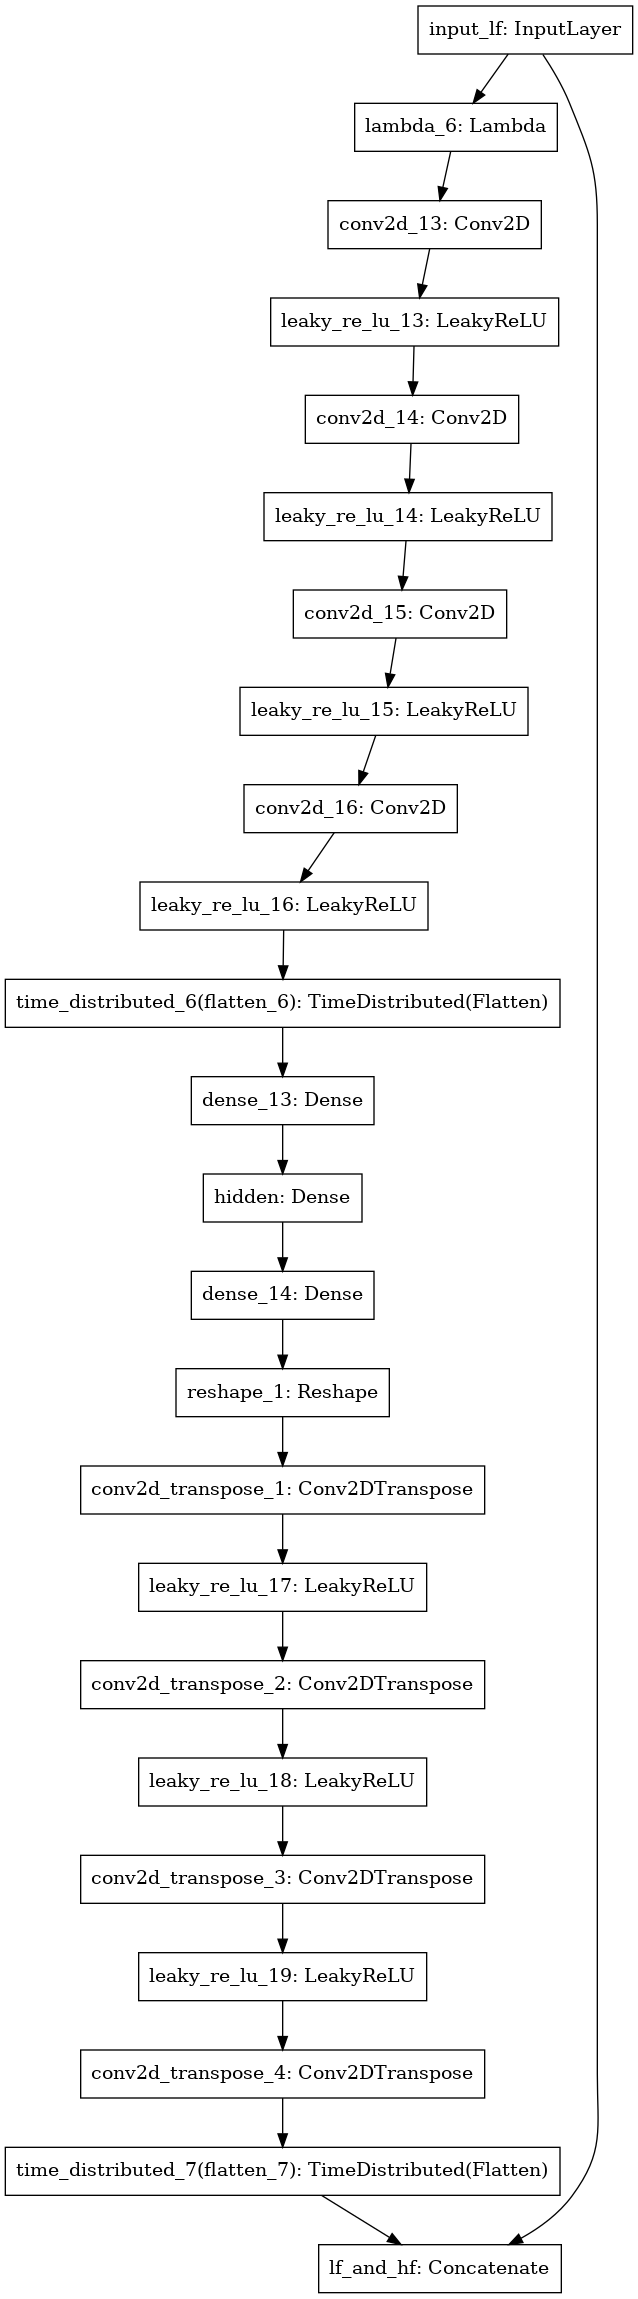

In [8]:
def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = Dense(1024, activation='tanh')(layer)
    layer = Dense(96, activation='tanh', name='hidden')(layer)
    layer = Dense(1024, activation='tanh')(layer)
    layer = Reshape((-1, 128,8))(layer)
    layer = LeakyReLU(0.05)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    layer = TimeDistributed(Flatten())(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, None, 129, 32 320         lambda_7[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_20 (LeakyReLU)      (None, None, 129, 32 0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 

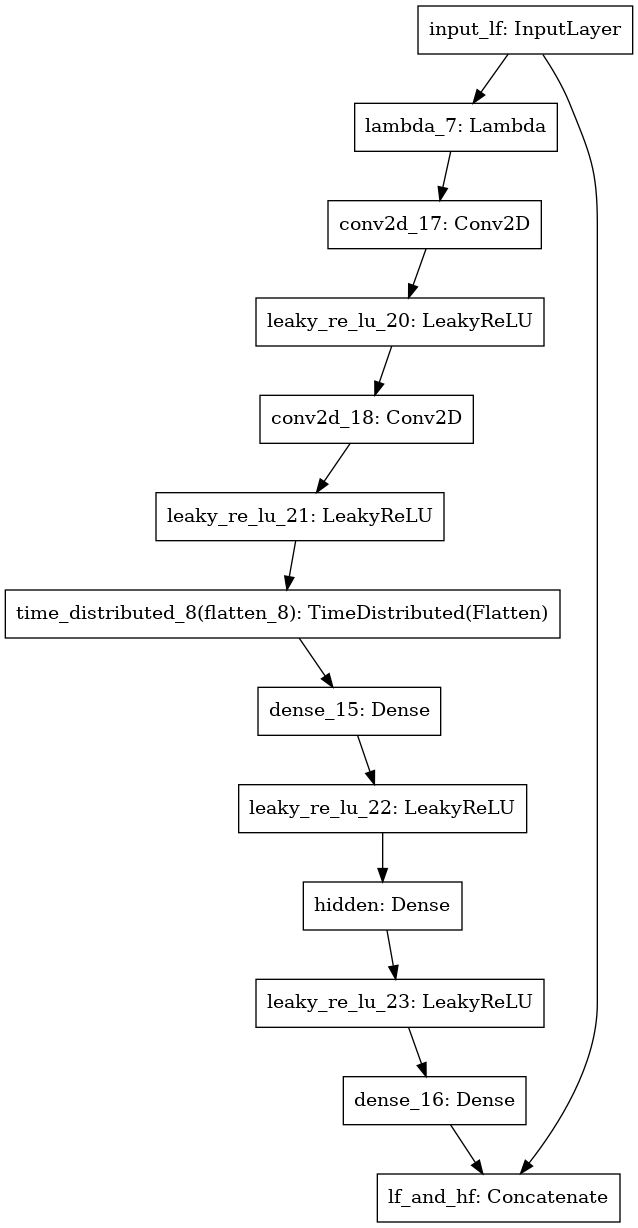

In [9]:
def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(32, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.05)(Dense(2048)(layer))
    layer = LeakyReLU(0.05)(Dense(2048, name='hidden')(layer))
    layer = Dense(128, activation='linear')(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, None, 129, 8) 80          lambda_8[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_24 (LeakyReLU)      (None, None, 129, 8) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 

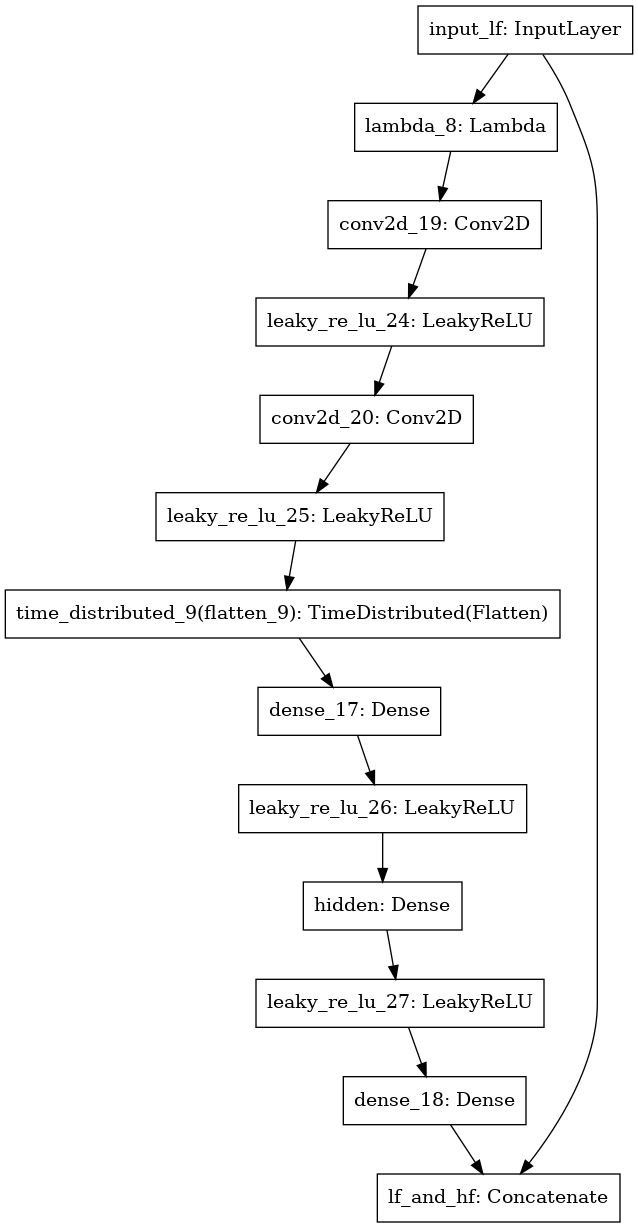

In [10]:
def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(8, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(8, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.05)(Dense(512)(layer))
    layer = LeakyReLU(0.05)(Dense(512, name='hidden')(layer))
    layer = Dense(128, activation='linear')(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, None, 129, 16 160         lambda_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_28 (LeakyReLU)      (None, None, 129, 16 0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 

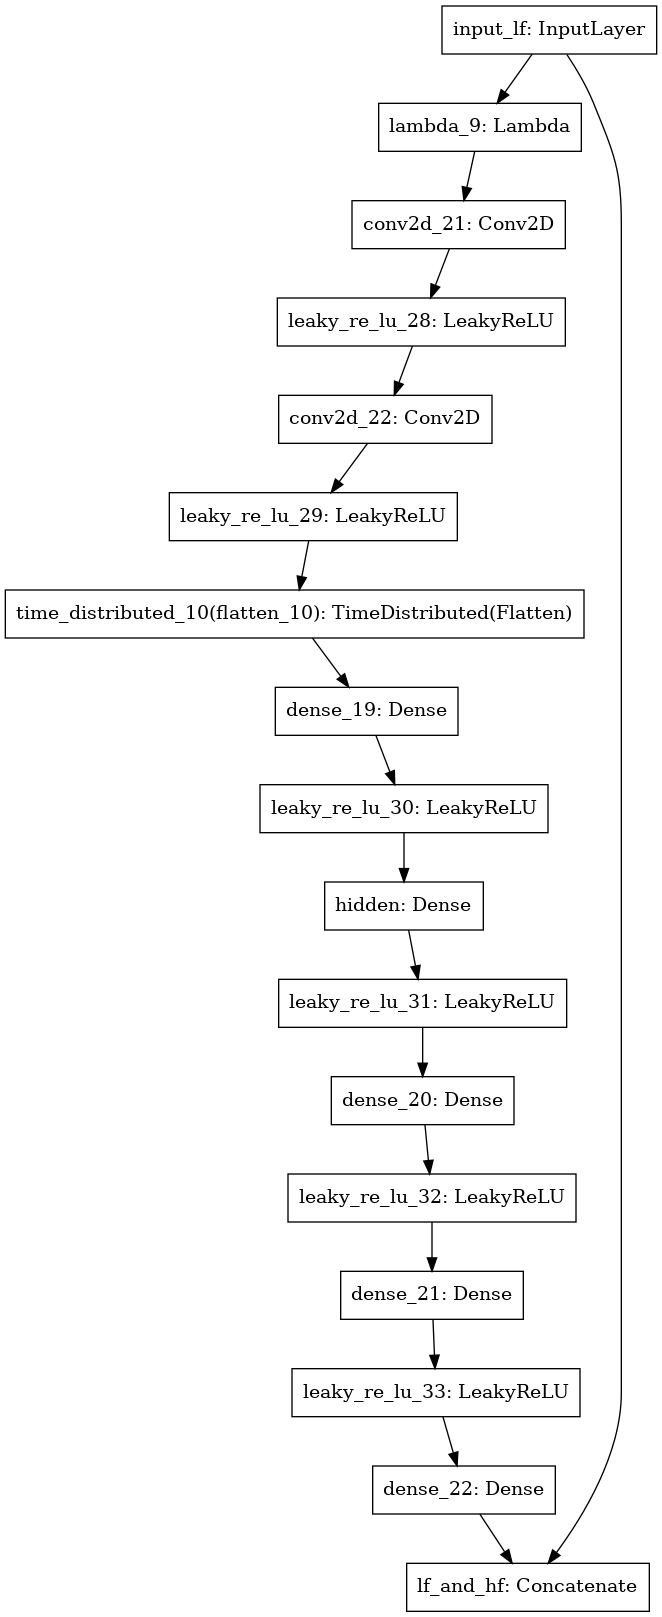

In [11]:
def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.05)(Dense(512)(layer))
    layer = LeakyReLU(0.05)(Dense(96, name='hidden')(layer))
    layer = LeakyReLU(0.05)(Dense(512)(layer))
    layer = LeakyReLU(0.05)(Dense(2048)(layer))
    layer = Dense(128)(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, None, 129, 16 160         lambda_10[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_34 (LeakyReLU)      (None, None, 129, 16 0           conv2d_23[0][0]                  
__________________________________________________________________________________________________
conv2d_24 

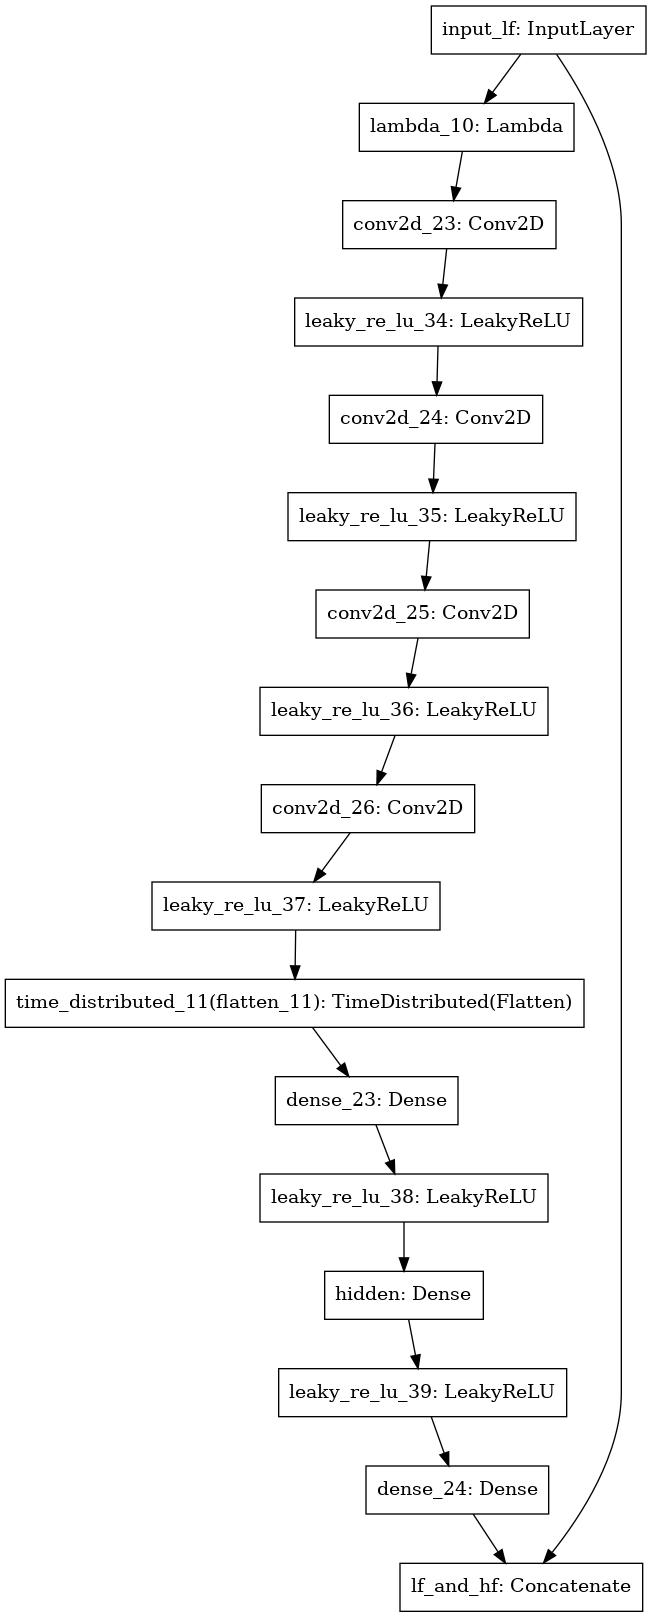

In [12]:
def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = LeakyReLU(0.05)(Dense(512, name='hidden')(layer))
    layer = Dense(128)(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, None, 129, 32 1472        lambda_11[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_40 (LeakyReLU)      (None, None, 129, 32 0           conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_28 

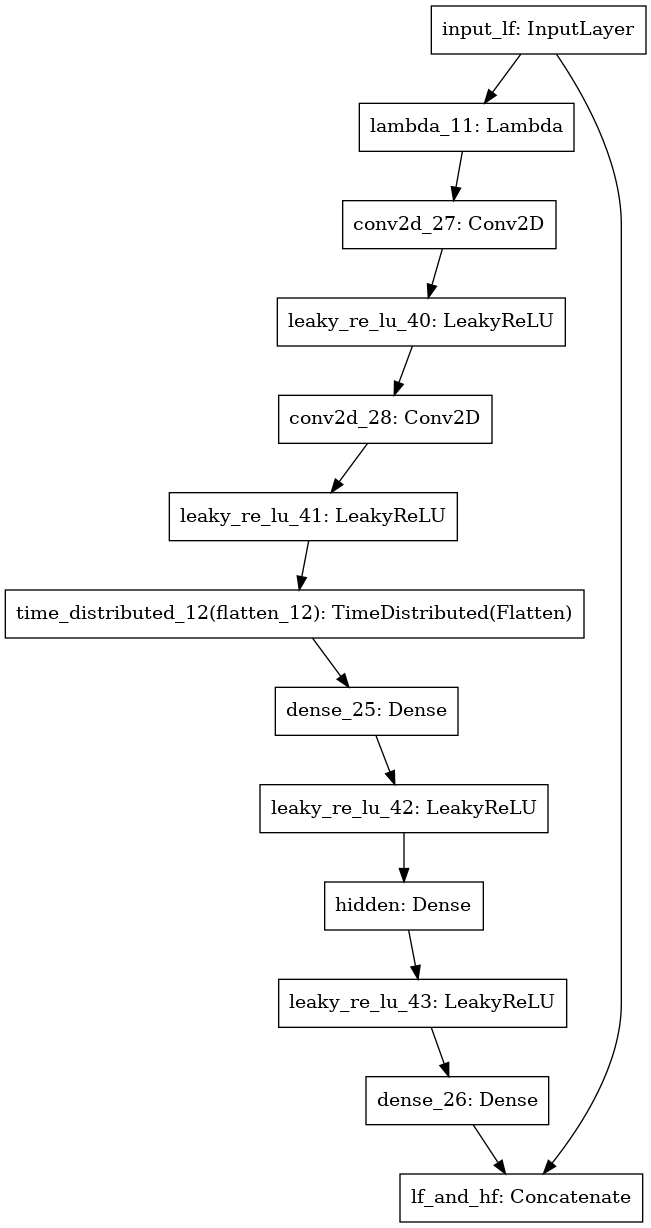

In [13]:
def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(32, kernel_size=(9,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(40, kernel_size=(9,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = LeakyReLU(0.05)(Dense(512, name='hidden')(layer))
    layer = Dense(128)(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, None, 129, 16 160         lambda_12[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_44 (LeakyReLU)      (None, None, 129, 16 0           conv2d_29[0][0]                  
__________________________________________________________________________________________________
conv2d_30 

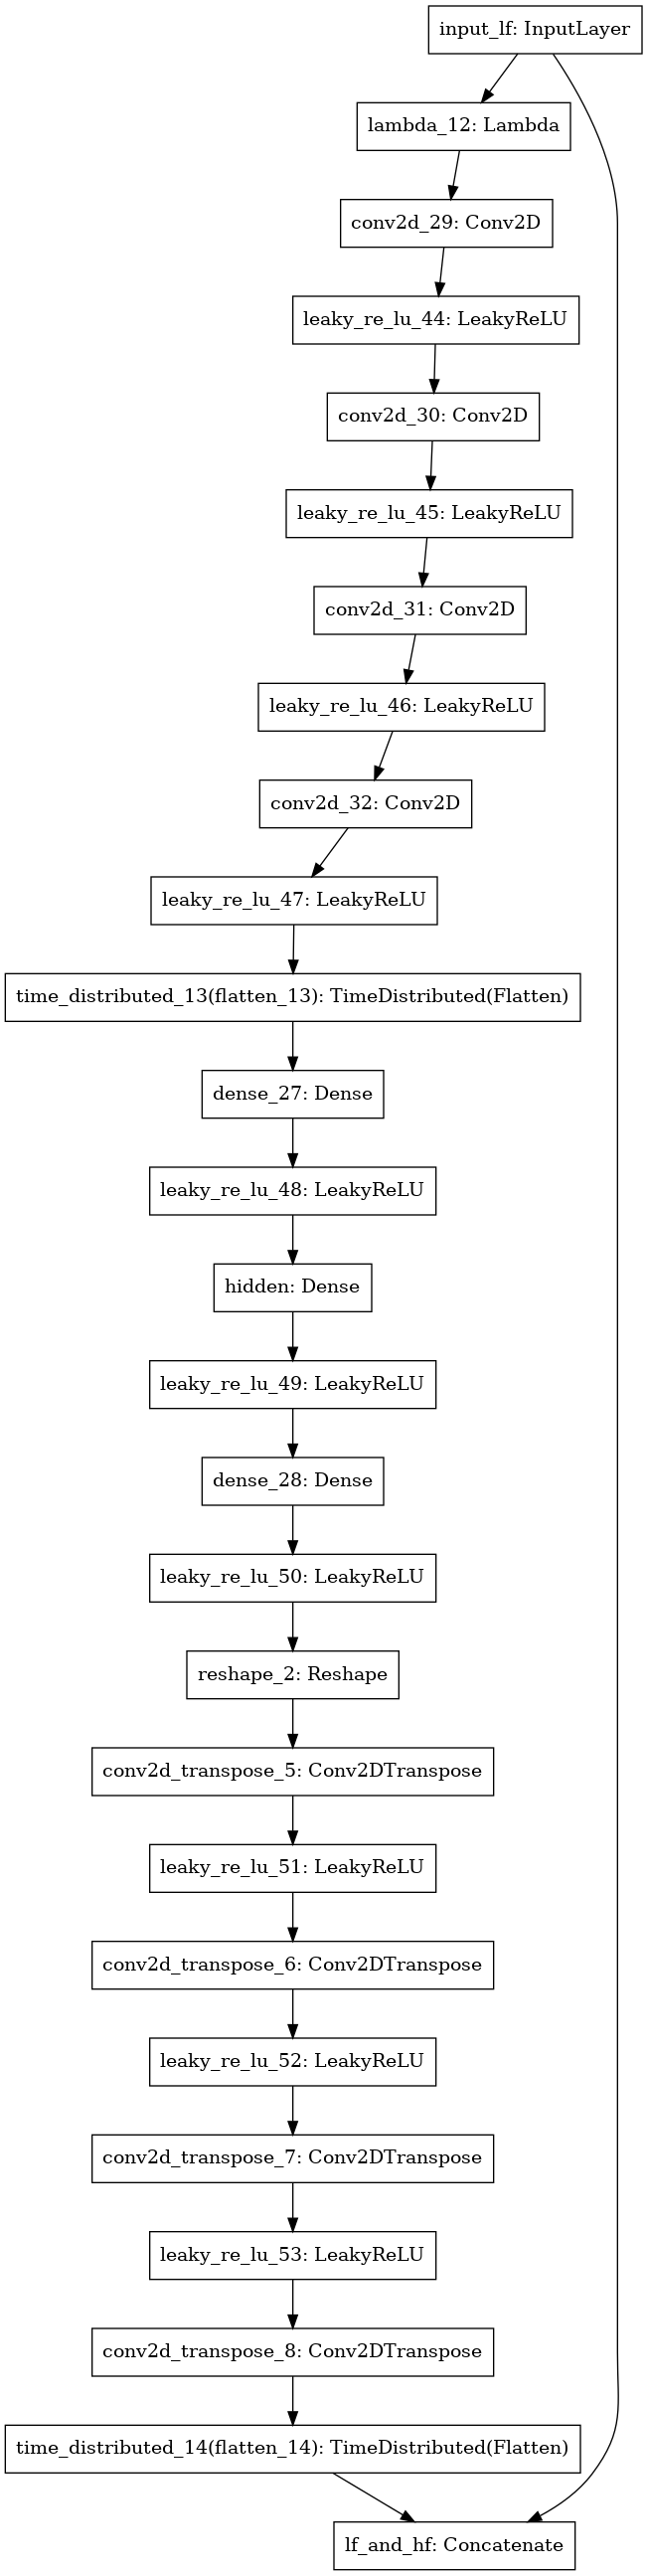

In [14]:
def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.05)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = LeakyReLU(0.05)(Dense(96, name='hidden')(layer))
    layer = LeakyReLU(0.05)(Dense(1024)(layer))
    layer = Reshape((-1, 128,8))(layer)
    layer = LeakyReLU(0.05)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.05)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    layer = TimeDistributed(Flatten())(layer)
    lf_and_hf = concatenate([input_lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

##### Data loading

In [32]:
TRAIN = 90 # 00
VALID = 80
TEST = 80

import numpy as np
import scipy.io.wavfile as sio
import gc

import tempfile
import subprocess

tempnam = tempfile.mktemp

log_fft_source = log_fft_target = phase = train = test = valid = experiment = None
gc.collect()

dataset = Dataset.from_folder("DAE-libri",
                              verbose = False,
                              dataset_pad = 8,
                              trim_lengths = 160000,
                              cache = "cache",
                              ram_cache_size = None,
                              filter=lambda x:x.endswith(".wav") and not x.endswith(".gsm.wav"))


log_fft_source = np.zeros([TRAIN + VALID + TEST, 1248, 129], np.float32)
log_fft_target = np.zeros([TRAIN + VALID + TEST, 1248, 257], np.float32)
phase = np.zeros([TEST, 1248, 129], np.float32)

for ix, file in enumerate(dataset.files[:TRAIN + VALID + TEST]):
    print(ix)
    data = sio.read(dataset.root + "/" + file)[1] # .astype(np.float32) to generate noise in the experiment...
    oldname = tempnam() + '.oldwav'
    sio.write(oldname, 16000, data)
    tmpname = tempnam() + '.gsm'
    newname = dataset.root + "/" + file + ".gsm.wav"
    subprocess.Popen(['sox', oldname, '-r', '8000', tmpname]).communicate()
    subprocess.Popen(['sox', tmpname, '-r', '16000', "-e", "signed", '-b', '16',  newname]).communicate()
    list(map(os.remove, [oldname, tmpname]))


window = np.hamming(512)
for ix, file in enumerate(dataset.files[:TRAIN + VALID + TEST]):
    print(ix)
    r = sio.read(dataset.root + "/" + file)[1].astype(np.float32)
    r /= 2**15
    for time in range(1248):
        win = r[128 * time : 128 * time + 512]
        if len(win) != 512:
            break
        fft = np.fft.rfft(window * win) / 512
        log_fft_target[ix, time, :] = -np.log(np.abs(fft) ** 2 + 2e-12)
    r = sio.read(dataset.root + "/" + file + ".gsm.wav")[1].astype(np.float32)
    r /= 2**15
    for time in range(1248):
        win = r[128 * time : 128 * time + 512]
        if len(win) != 512:
            break
        fft = np.fft.rfft(window * win) / 512
        log_fft_source[ix, time, :] = -np.log(np.abs(fft) ** 2 + 2e-12)[:129]
        if ix >= TRAIN+VALID:
            phase[ix - TRAIN - VALID, time, :] = np.angle(fft)[:129]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [33]:
MEAN = 0 # min([log_fft_source.min(), log_fft_target.min()])
mean = log_fft_source.mean()
#log_fft_source -= MEAN
#log_fft_target -= MEAN
STD = []
for i in range(log_fft_source.shape[0]):
    rec = (log_fft_source[i] - mean) ** 2
    STD.append(rec.mean())
STD = np.sqrt(np.array(STD).mean())
log_fft_source /= STD
log_fft_target /= STD
print(log_fft_source.min(), log_fft_source.max())

0.0 4.09569


In [34]:
train = log_fft_source[:TRAIN,:,:129], log_fft_target[:TRAIN]
valid = log_fft_source[TRAIN:TRAIN+VALID,:,:129], log_fft_target[TRAIN:TRAIN+VALID]
test = log_fft_source[TRAIN+VALID:TRAIN+VALID+TEST,:,:129], log_fft_target[TRAIN+VALID:TRAIN+VALID+TEST]

##### Training

In [ ]:
models = None
gc.collect()

0

In [ ]:
"""
To experiment add:
    printing experiment name
    saving progress to make it probeable
    callbacks of convergence
"""

class StopOnConvergence(Callback):
    """Callback that terminates training when a NaN loss is encountered.
    """

    def __init__(self, max_repetitions=10):
        super().__init__()
        self.max_repetitions = max_repetitions
    
    def on_train_begin(self, logs=None):
        self.repetitions = 0
        self.last_loss = np.inf
    
    def on_epoch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('val_loss')
        if loss is not None:
            if loss > self.last_loss:
                self.repetitions += 1
            else:
                self.last_loss = loss
                self.repetitions = 0
            if self.repetitions > self.max_repetitions:
                self.model.stop_training = True


experiment_names = []

# assert that all models have a layer with hidden representation
for mk_model in model_callbacks:
    mdl = mk_model()
    assert len([x.name for x in mdl.layers if x.name == "hidden"]) == 1

for mk_model in model_callbacks:
    experiment = SingleExperiment(mk_model, train = train, valid = valid, test = test, run_parameters={"batch_size": 8})
    experiment.add_schedule(Schedule([0.001, 0.0001, 0.00001], [100, 100, 100], lambda rate: keras.optimizers.Adam(rate, clipvalue = 1.)))
    experiment.add_measure(MSE(), name='mse')
    experiment.add_callback(StopOnConvergence(8))
    experiment.run()
    experiment_names.append(experiment.name)
    experiment.report()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, None, 129, 32 320         lambda_13[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_54 (LeakyReLU)      (None, None, 129, 32 0           conv2d_33[0][0]                  
__________________________________________________________________________________________________
conv2d_34 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_17 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, None, 129, 32 1472        lambda_17[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_64 (LeakyReLU)      (None, None, 129, 32 0           conv2d_43[0][0]                  
__________________________________________________________________________________________________
conv2d_44 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_21 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, None, 129, 16 160         lambda_21[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_81 (LeakyReLU)      (None, None, 129, 16 0           conv2d_53[0][0]                  
__________________________________________________________________________________________________
conv2d_54 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_24 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, None, 129, 16 160         lambda_24[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_97 (LeakyReLU)      (None, None, 129, 16 0           conv2d_61[0][0]                  
__________________________________________________________________________________________________
conv2d_62 

Train on 9000 samples, validate on 80 samples
Epoch 1/100
9000/9000 [==============================] - 159s 18ms/step - loss: 3.4494 - val_loss: 3.4685
Epoch 2/100
9000/9000 [==============================] - 153s 17ms/step - loss: 3.4363 - val_loss: 3.4825
Epoch 3/100
9000/9000 [==============================] - 153s 17ms/step - loss: 3.4361 - val_loss: 3.4851
Epoch 4/100
9000/9000 [==============================] - 152s 17ms/step - loss: 3.4241 - val_loss: 3.3658
Epoch 5/100
9000/9000 [==============================] - 153s 17ms/step - loss: 3.2979 - val_loss: 3.3072
Epoch 6/100
9000/9000 [==============================] - 153s 17ms/step - loss: 3.2723 - val_loss: 3.2954
Epoch 7/100
9000/9000 [==============================] - 153s 17ms/step - loss: 3.2519 - val_loss: 3.2853
Epoch 8/100
9000/9000 [==============================] - 153s 17ms/step - loss: 3.2485 - val_loss: 3.2855
Epoch 9/100
9000/9000 [==============================] - 153s 17ms/step - loss: 3.2482 - val_loss: 3.2767


Train on 9000 samples, validate on 80 samples
Epoch 1/100
9000/9000 [==============================] - 47s 5ms/step - loss: 3.3927 - val_loss: 3.3339
Epoch 2/100
9000/9000 [==============================] - 45s 5ms/step - loss: 3.2802 - val_loss: 3.3361
Epoch 3/100
9000/9000 [==============================] - 45s 5ms/step - loss: 3.2683 - val_loss: 3.3404
Epoch 4/100
9000/9000 [==============================] - 45s 5ms/step - loss: 3.2633 - val_loss: 3.3380
Epoch 5/100
9000/9000 [==============================] - 45s 5ms/step - loss: 3.2561 - val_loss: 3.3070
Epoch 6/100
9000/9000 [==============================] - 45s 5ms/step - loss: 3.2515 - val_loss: 3.3200
Epoch 7/100
9000/9000 [==============================] - 44s 5ms/step - loss: 3.2468 - val_loss: 3.3016
Epoch 8/100
9000/9000 [==============================] - 45s 5ms/step - loss: 3.2417 - val_loss: 3.2872
Epoch 9/100
9000/9000 [==============================] - 45s 5ms/step - loss: 3.2392 - val_loss: 3.2885
Epoch 10/100
9000/

9000/9000 [==============================] - 80s 9ms/step - loss: 3.2103 - val_loss: 3.2620
Epoch 26/100
9000/9000 [==============================] - 80s 9ms/step - loss: 3.2032 - val_loss: 3.2685
Epoch 27/100
9000/9000 [==============================] - 80s 9ms/step - loss: 3.2035 - val_loss: 3.2929
Epoch 28/100
9000/9000 [==============================] - 80s 9ms/step - loss: 3.2017 - val_loss: 3.2621
Epoch 29/100
9000/9000 [==============================] - 80s 9ms/step - loss: 3.2011 - val_loss: 3.2671
Epoch 30/100
9000/9000 [==============================] - 80s 9ms/step - loss: 3.2013 - val_loss: 3.2640
Epoch 31/100
9000/9000 [==============================] - 80s 9ms/step - loss: 3.2001 - val_loss: 3.2722
Epoch 32/100
9000/9000 [==============================] - 80s 9ms/step - loss: 3.2001 - val_loss: 3.2615
Epoch 33/100
9000/9000 [==============================] - 80s 9ms/step - loss: 3.1979 - val_loss: 3.2678
Epoch 34/100
9000/9000 [==============================] - 80s 9ms/st

Train on 9000 samples, validate on 80 samples
Epoch 1/100
9000/9000 [==============================] - 161s 18ms/step - loss: 3.4697 - val_loss: 3.4570
Epoch 2/100
9000/9000 [==============================] - 158s 18ms/step - loss: 3.4131 - val_loss: 3.4611
Epoch 3/100
9000/9000 [==============================] - 158s 18ms/step - loss: 3.4149 - val_loss: 3.4605
Epoch 4/100
9000/9000 [==============================] - 158s 18ms/step - loss: 3.4147 - val_loss: 3.4832
Epoch 5/100
9000/9000 [==============================] - 157s 17ms/step - loss: 3.4157 - val_loss: 3.4633
Epoch 6/100
9000/9000 [==============================] - 158s 18ms/step - loss: 3.4165 - val_loss: 3.4633
Epoch 7/100
9000/9000 [==============================] - 157s 17ms/step - loss: 3.4154 - val_loss: 3.4633
Epoch 8/100
9000/9000 [==============================] - 157s 17ms/step - loss: 3.4197 - val_loss: 3.4634
Epoch 9/100
9000/9000 [==============================] - 158s 18ms/step - loss: 3.4138 - val_loss: 3.4581


Epoch 67/100
9000/9000 [==============================] - 159s 18ms/step - loss: 3.2046 - val_loss: 3.2657
Epoch 68/100
9000/9000 [==============================] - 159s 18ms/step - loss: 3.2044 - val_loss: 3.2667
Epoch 69/100
9000/9000 [==============================] - 160s 18ms/step - loss: 3.2041 - val_loss: 3.2646
Epoch 70/100
9000/9000 [==============================] - 160s 18ms/step - loss: 3.2041 - val_loss: 3.2646
Epoch 71/100
9000/9000 [==============================] - 160s 18ms/step - loss: 3.2035 - val_loss: 3.2675
Epoch 72/100
9000/9000 [==============================] - 159s 18ms/step - loss: 3.2031 - val_loss: 3.2652
Epoch 73/100
9000/9000 [==============================] - 159s 18ms/step - loss: 3.2038 - val_loss: 3.2620
Epoch 74/100
9000/9000 [==============================] - 159s 18ms/step - loss: 3.2026 - val_loss: 3.2666
Epoch 75/100
9000/9000 [==============================] - 160s 18ms/step - loss: 3.2026 - val_loss: 3.2641
Epoch 76/100
9000/9000 [=============

9000/9000 [==============================] - 226s 25ms/step - loss: 3.4144 - val_loss: 3.4576
Epoch 13/100
9000/9000 [==============================] - 224s 25ms/step - loss: 3.4162 - val_loss: 3.4621
Epoch 14/100
9000/9000 [==============================] - 225s 25ms/step - loss: 3.4151 - val_loss: 3.4592
Train on 9000 samples, validate on 80 samples
Epoch 1/100
9000/9000 [==============================] - 229s 25ms/step - loss: 3.4072 - val_loss: 3.4569
Epoch 2/100
9000/9000 [==============================] - 226s 25ms/step - loss: 3.4070 - val_loss: 3.4568
Epoch 3/100
9000/9000 [==============================] - 227s 25ms/step - loss: 3.4072 - val_loss: 3.4558
Epoch 4/100
9000/9000 [==============================] - 228s 25ms/step - loss: 3.3881 - val_loss: 3.3904
Epoch 5/100
9000/9000 [==============================] - 228s 25ms/step - loss: 3.3137 - val_loss: 3.3488
Epoch 6/100
9000/9000 [==============================] - 229s 25ms/step - loss: 3.2851 - val_loss: 3.3301
Epoch 7/10

Train on 9000 samples, validate on 80 samples
Epoch 1/100
9000/9000 [==============================] - 266s 30ms/step - loss: 3.5823 - val_loss: 3.4596
Epoch 2/100
9000/9000 [==============================] - 262s 29ms/step - loss: 3.4188 - val_loss: 3.4564
Epoch 3/100
9000/9000 [==============================] - 261s 29ms/step - loss: 3.4176 - val_loss: 3.4650
Epoch 4/100
9000/9000 [==============================] - 261s 29ms/step - loss: 3.4131 - val_loss: 3.4552
Epoch 5/100
9000/9000 [==============================] - 261s 29ms/step - loss: 3.4121 - val_loss: 3.4541
Epoch 6/100
9000/9000 [==============================] - 262s 29ms/step - loss: 3.4133 - val_loss: 3.4666
Epoch 7/100
9000/9000 [==============================] - 261s 29ms/step - loss: 3.4119 - val_loss: 3.4605
Epoch 8/100
9000/9000 [==============================] - 262s 29ms/step - loss: 3.4114 - val_loss: 3.4585
Epoch 9/100
9000/9000 [==============================] - 262s 29ms/step - loss: 3.4111 - val_loss: 3.4550


Epoch 63/100
9000/9000 [==============================] - 262s 29ms/step - loss: 3.1914 - val_loss: 3.2594
Epoch 64/100
9000/9000 [==============================] - 262s 29ms/step - loss: 3.1905 - val_loss: 3.2548
Epoch 65/100
9000/9000 [==============================] - 262s 29ms/step - loss: 3.1910 - val_loss: 3.2571
Epoch 66/100
9000/9000 [==============================] - 262s 29ms/step - loss: 3.1900 - val_loss: 3.2545
Epoch 67/100
9000/9000 [==============================] - 261s 29ms/step - loss: 3.1895 - val_loss: 3.2626
Epoch 68/100
9000/9000 [==============================] - 262s 29ms/step - loss: 3.1892 - val_loss: 3.2542
Epoch 69/100
9000/9000 [==============================] - 261s 29ms/step - loss: 3.1887 - val_loss: 3.2553
Epoch 70/100
9000/9000 [==============================] - 261s 29ms/step - loss: 3.1883 - val_loss: 3.2559
Epoch 71/100
9000/9000 [==============================] - 262s 29ms/step - loss: 3.1881 - val_loss: 3.2544
Epoch 72/100
9000/9000 [=============

Train on 9000 samples, validate on 80 samples
Epoch 1/100
9000/9000 [==============================] - 55s 6ms/step - loss: 3.4995 - val_loss: 3.4250
Epoch 2/100
9000/9000 [==============================] - 51s 6ms/step - loss: 3.3465 - val_loss: 3.3770
Epoch 3/100
9000/9000 [==============================] - 52s 6ms/step - loss: 3.3310 - val_loss: 3.3664
Epoch 4/100
9000/9000 [==============================] - 52s 6ms/step - loss: 3.3224 - val_loss: 3.3658
Epoch 5/100
9000/9000 [==============================] - 52s 6ms/step - loss: 3.3030 - val_loss: 3.3323
Epoch 6/100
9000/9000 [==============================] - 51s 6ms/step - loss: 3.2975 - val_loss: 3.3270
Epoch 7/100
9000/9000 [==============================] - 51s 6ms/step - loss: 3.2819 - val_loss: 3.3311
Epoch 8/100
9000/9000 [==============================] - 52s 6ms/step - loss: 3.2715 - val_loss: 3.3326
Epoch 9/100
9000/9000 [==============================] - 51s 6ms/step - loss: 3.2704 - val_loss: 3.3124
Epoch 10/100
9000/

In [23]:
with open("/tmp/test_data.bin", "wb") as f:
    pickle.dump((test, phase), f)
    
with open("/tmp/data_norm.bin", "wb") as f:
    pickle.dump((MEAN, STD), f)

In [22]:
experiment_names

['./runs/1538225824.385981',
 './runs/1538236198.5314517',
 './runs/1538240803.5992877',
 './runs/1538246812.7872143',
 './runs/1538265125.1409142',
 './runs/1538293959.7829702',
 './runs/1538322508.6296325',
 './runs/1538333074.5223124',
 './runs/1538340279.960233',
 './runs/1538345780.2921503',
 './runs/1538355414.9699898',
 './runs/1538371959.3982468']

### After reset

##### Load models and data

In [1]:
# import from first cell after restarting kernel

experiment_names = ['./runs/1538225824.385981',
 './runs/1538236198.5314517',
 './runs/1538240803.5992877',
 './runs/1538246812.7872143',
 './runs/1538265125.1409142',
 './runs/1538293959.7829702',
 './runs/1538322508.6296325',
 './runs/1538333074.5223124',
 './runs/1538340279.960233',
 './runs/1538345780.2921503',
 './runs/1538355414.9699898',
 './runs/1538371959.3982468']

In [48]:
with open("/tmp/test_data.bin", "rb") as f:
    test, phase = pickle.load(f)
    
with open("/tmp/data_norm.bin", "rb") as f:
    MEAN, STD = pickle.load(f) #, phase = pickle.load(f)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_25 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, None, 129, 32 320         lambda_25[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_107 (LeakyReLU)     (None, None, 129, 32 0           conv2d_65[0][0]                  
__________________________________________________________________________________________________
conv2d_66 

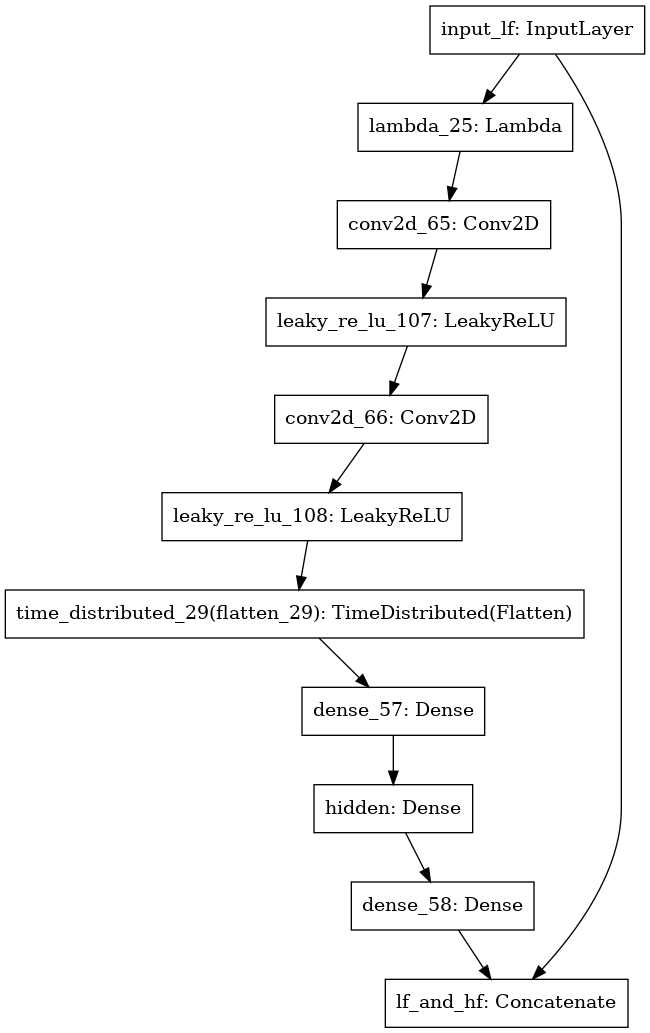

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_26 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, None, 129, 8) 80          lambda_26[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_109 (LeakyReLU)     (None, None, 129, 8) 0           conv2d_67[0][0]                  
__________________________________________________________________________________________________
conv2d_68 

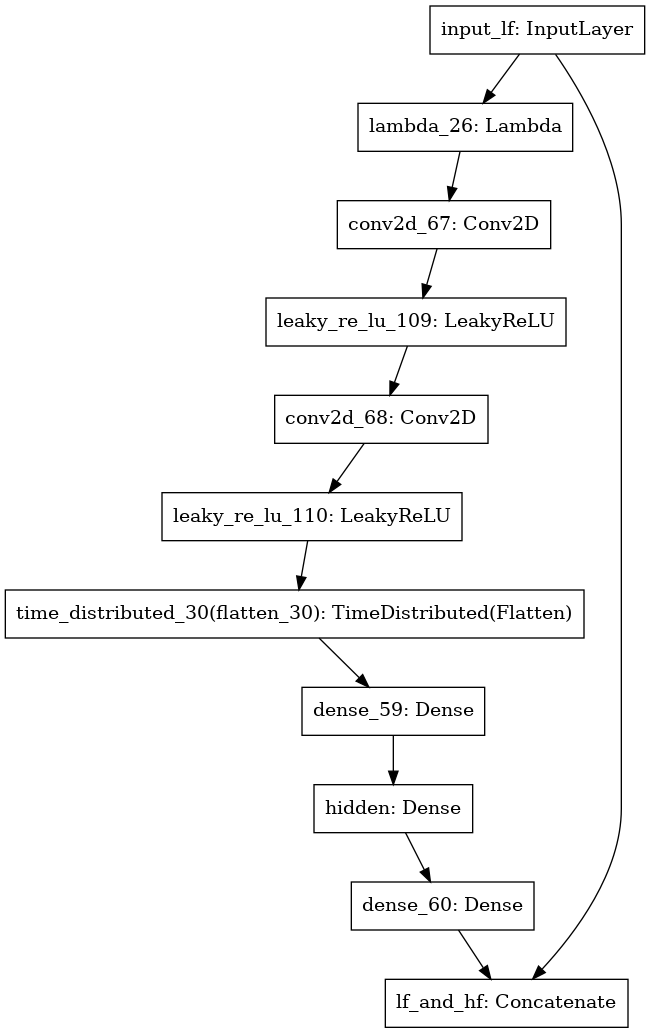

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_27 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, None, 129, 16 160         lambda_27[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_111 (LeakyReLU)     (None, None, 129, 16 0           conv2d_69[0][0]                  
__________________________________________________________________________________________________
conv2d_70 

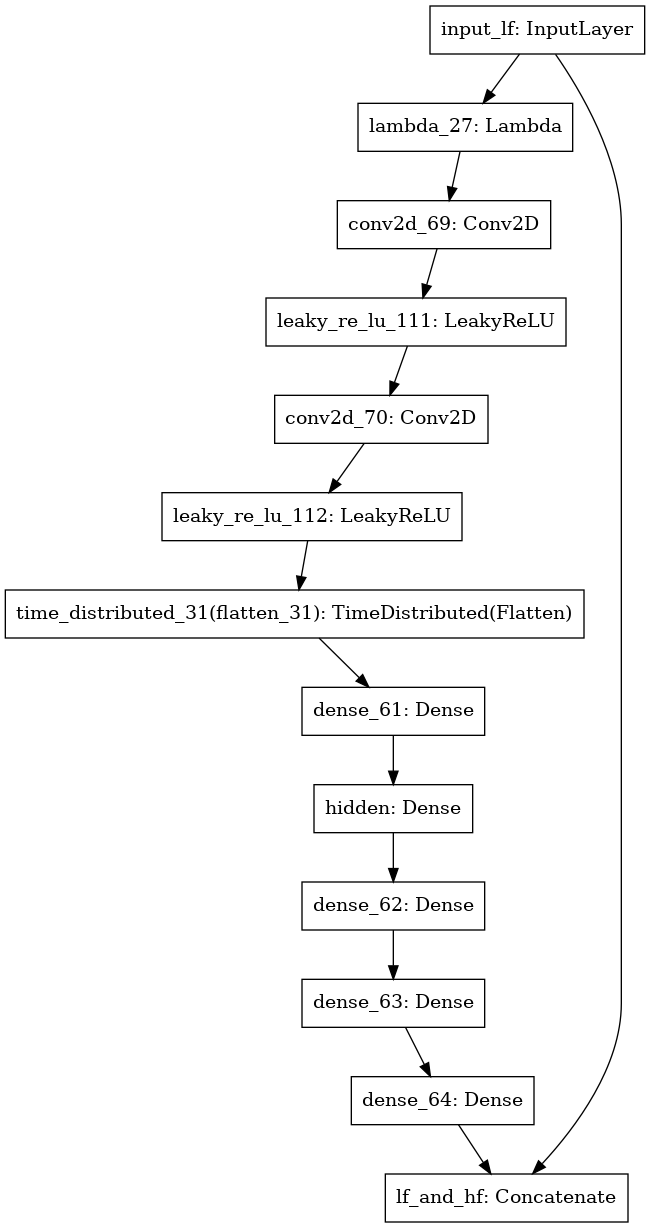

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_28 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, None, 129, 16 160         lambda_28[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_113 (LeakyReLU)     (None, None, 129, 16 0           conv2d_71[0][0]                  
__________________________________________________________________________________________________
conv2d_72 

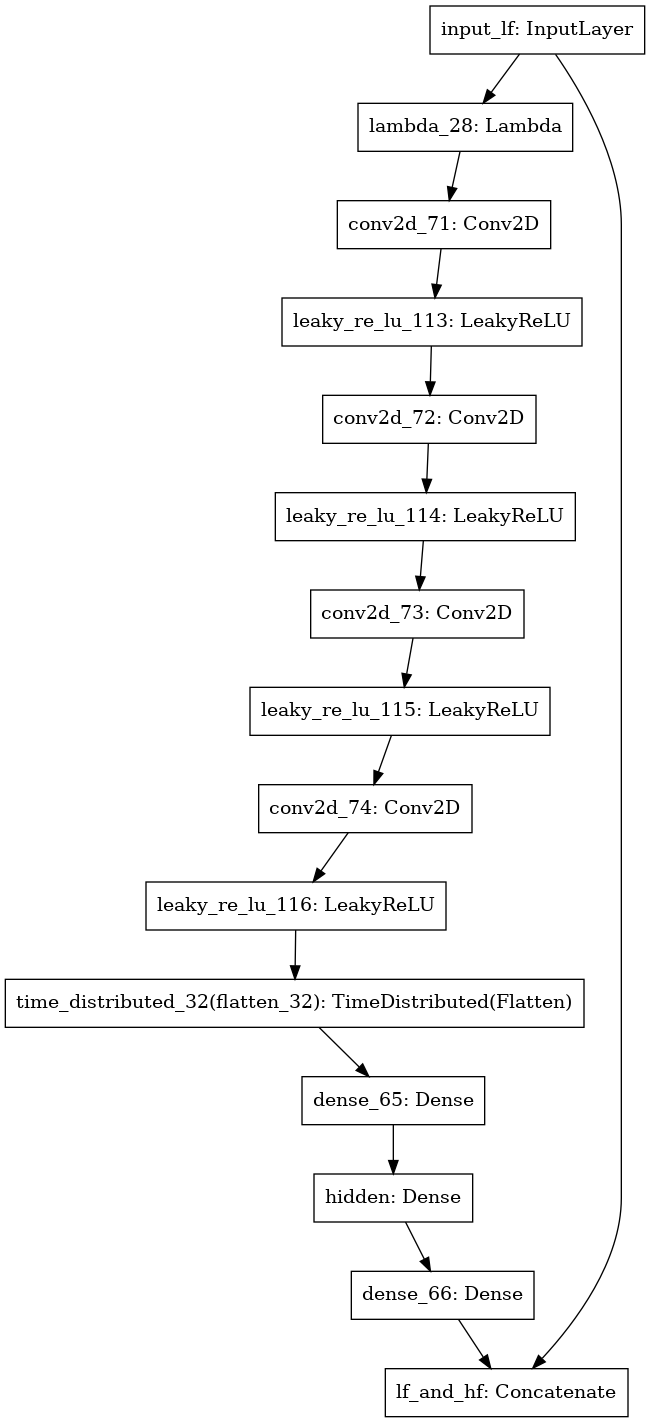

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_29 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, None, 129, 32 1472        lambda_29[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_117 (LeakyReLU)     (None, None, 129, 32 0           conv2d_75[0][0]                  
__________________________________________________________________________________________________
conv2d_76 

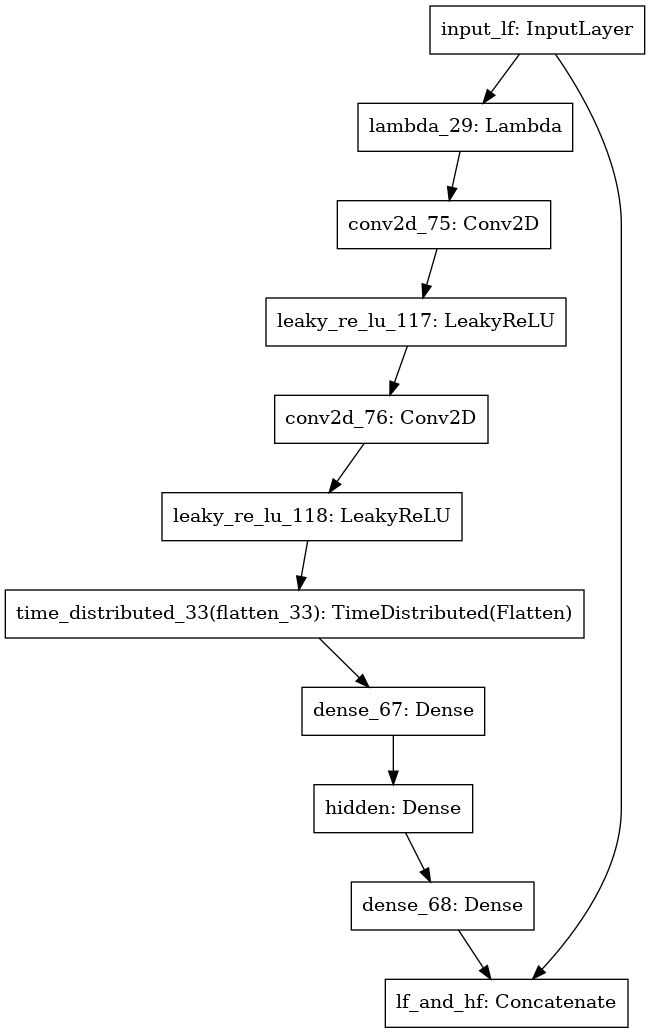

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_30 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, None, 129, 16 160         lambda_30[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_119 (LeakyReLU)     (None, None, 129, 16 0           conv2d_77[0][0]                  
__________________________________________________________________________________________________
conv2d_78 

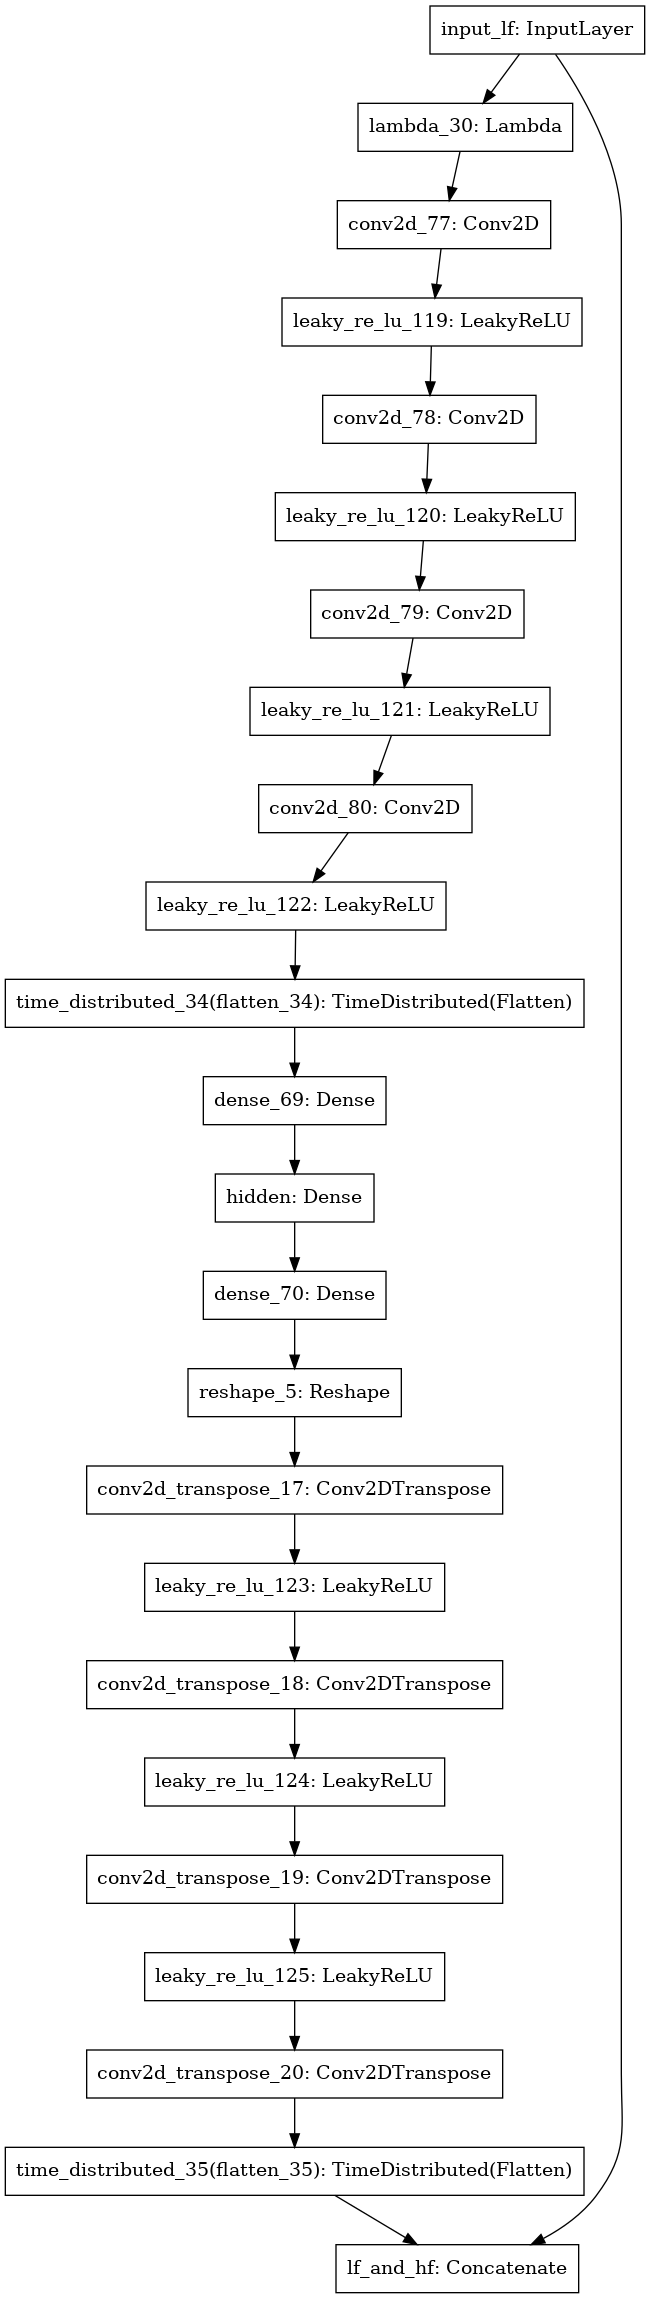

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_31 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, None, 129, 32 320         lambda_31[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_126 (LeakyReLU)     (None, None, 129, 32 0           conv2d_81[0][0]                  
__________________________________________________________________________________________________
conv2d_82 

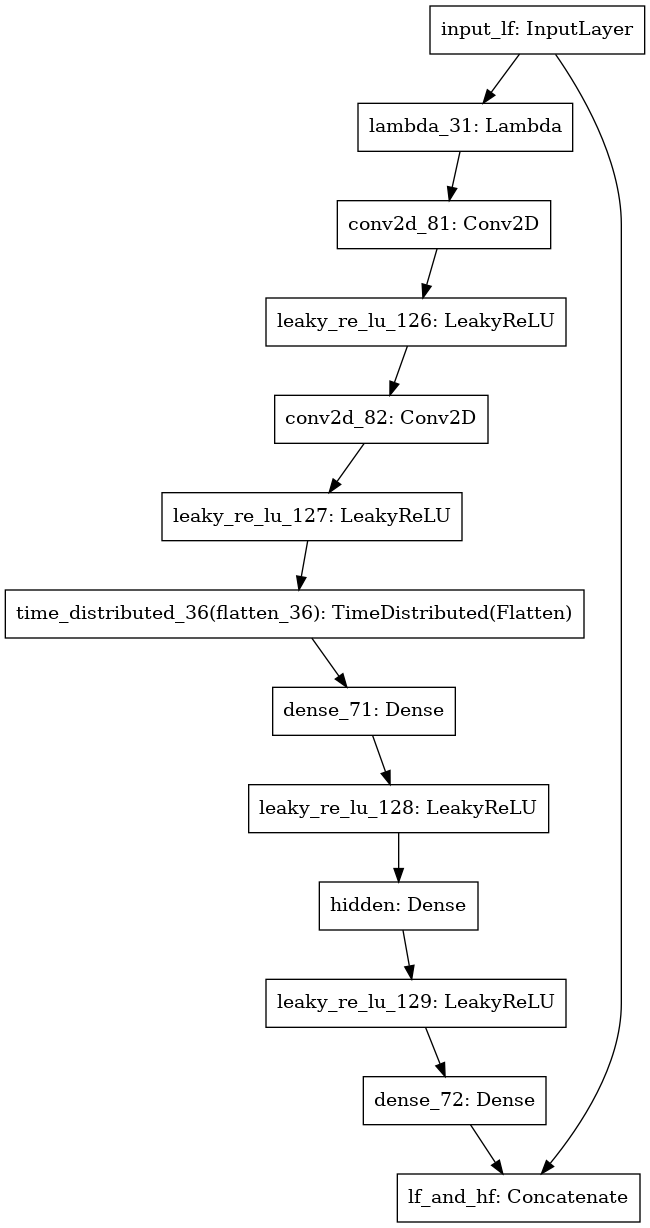

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_32 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_83 (Conv2D)              (None, None, 129, 8) 80          lambda_32[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_130 (LeakyReLU)     (None, None, 129, 8) 0           conv2d_83[0][0]                  
__________________________________________________________________________________________________
conv2d_84 

In [ ]:
models = []

for model in experiment_names:
    mdl = Estimator.only_model(model)
    mdl.summary()
    print("-----\n" + model)
    models.append(mdl)
    try:
        temp = tempfile.mktemp() + ".png"
        plot_model(mdl, to_file=temp)
        display(Image(filename=temp))
    except:
        pass

In [ ]:
# visualisation

image, gt = test

plt.figure(figsize=(15,10))
plt.title("Baseline image")
plt.imshow(np.rot90(gt[0, :, :]), aspect='auto')
plt.show()

for name, mdl in zip(experiment_names, models):
    prediction = mdl.predict(image[:1])
    plt.figure(figsize=(15,10))
    plt.title("Experiment: " + name)
    plt.imshow(np.rot90(prediction[0, :, :]), aspect='auto')
    plt.show()

In [ ]:
# visualisation with substituted lower frequencies (because GSM makes them less dynamic)

image, gt = test

plt.figure(figsize=(15,10))
plt.title("Baseline image")
plt.imshow(np.rot90(gt[0, :, :]), aspect='auto')
plt.show()

for name, mdl in zip(experiment_names, models):
    prediction = mdl.predict(image[:1])
    prediction[0, :, :129] = gt[0, :, :129]
    plt.figure(figsize=(15,10))
    plt.title("Experiment: " + name)
    plt.imshow(np.rot90(prediction[0, :, :]), aspect='auto')
    plt.show()

In [ ]:
# visualisation

image, gt = test

plt.figure(figsize=(15,10))
plt.title("Baseline image")
plt.imshow(np.rot90(gt[0, :, 129:]), aspect='auto')
plt.show()

for name, mdl in zip(experiment_names, models):
    prediction = mdl.predict(image[:1])
    plt.figure(figsize=(15,10))
    plt.title("Experiment: " + name)
    plt.imshow(np.rot90(prediction[0, :, 129:]), aspect='auto')
    plt.colorbar()
    plt.show()
    
for name, mdl in zip(experiment_names, models):
    prediction = mdl.predict(image[:1])
    plt.figure(figsize=(15,10))
    plt.title("Difference of HF to baseline in experiment: " + name)
    plt.imshow(np.rot90(prediction[0, :, 129:] - gt[0, :, 129:]), aspect='auto')
    plt.colorbar()
    plt.show()

In [ ]:
# hidden representation of each model - verify variability

image, gt = test

for name, mdl in zip(experiment_names, models):
    model = Model(mdl.input, [x.output for x in mdl.layers if x.name == "hidden"][0])
    prediction = model.predict(image[:1])
    plt.figure(figsize=(15,10))
    plt.title("Hidden layer of: " + name)
    plt.imshow(np.rot90(prediction[0, :, :]), aspect='auto', vmin=-1, vmax=1)
    plt.show()

In [ ]:
# predicted spectrograms

old_phase = phase.copy()
phase = gt[:] * 0
phase[:, :, :129] = old_phase[:, :, :129]
window = np.hamming(512)

print("Groundtruth signal")
sound = gt[0] * STD + MEAN
spec = (np.sqrt(np.exp(-sound)) * 512) * np.exp(phase[0, :, :] * 1j)
length = len(np.where((gt[0, :, :] != 0).sum(1))[0]) - 4
sound = np.zeros(length * 128 + 512 - 128)
for i in range(length):
    frame = np.fft.irfft(spec[i,:])
    sound[128 * i : 128 * i + 512] += window * frame
plt.figure(figsize=(15,5))
plt.plot(sound[:-1024])
plt.show()
display(Audio(sound[:-1024], rate=16000))

print("Input signal")
sound = image[0] * STD + MEAN
spec = gt[0] * 0
spec[:,:129] = (np.sqrt(np.exp(-sound)) * 512) * np.exp(phase[0, :, :129] * 1j)
sound = np.zeros(length * 128 + 512 - 128)
for i in range(length):
    frame = np.fft.irfft(spec[i,:])
    sound[128 * i : 128 * i + 512] += window * frame
plt.figure(figsize=(15,5))
plt.plot(sound[:-1024])
plt.show()
display(Audio(sound[:-1024], rate=16000))


for name, mdl in zip(experiment_names, models):
    print("Prediction of " + name)
    spec = mdl.predict(image[:1])[0]
    sound = np.zeros(length * 128 + 512 - 128)
    spec *= STD
    spec += MEAN
    spec = (np.sqrt(np.exp(-spec)) * 512) * np.exp(phase[0, :, :] * 1j)
    for i in range(length):
        frame = np.fft.irfft(spec[i,:])
        sound[128 * i : 128 * i + 512] += window * frame
    plt.figure(figsize=(15,5))
    plt.plot(sound[:-1024])
    plt.show()
    display(Audio(sound[:-1024], rate=16000))


##### Metrics

In [ ]:
import subprocess
import re

def pesq(gt, pred, phase):
    spec = (np.sqrt(np.exp(-gt)) * 512) * np.exp(phase * 1j)
    sound = np.zeros(spec.shape[0] * 128 + 512 - 128)
    for i in range(spec.shape[0]):
        frame = np.fft.irfft(spec[i,:])
        sound[128 * i : 128 * i + 512] += frame
    spec = (np.sqrt(np.exp(-pred)) * 512) * np.exp(phase * 1j)
    sound2 = np.zeros(spec.shape[0] * 128 + 512 - 128)
    for i in range(spec.shape[0]):
        frame = np.fft.irfft(spec[i,:])
        sound2[128 * i : 128 * i + 512] += frame
    fname_gt = tempfile.mktemp() + ".wav"
    fname_pred = tempfile.mktemp() + ".wav"
    # print(sound.shape, sound2.shape)
    sio.write(fname_gt, 16000, (2**15 * sound).astype(np.int16))
    sio.write(fname_pred, 16000, (2**15 * sound2).astype(np.int16))
    ot,e = subprocess.Popen(["PESQ", "+wb", "+16000", fname_gt, fname_pred], stdout = subprocess.PIPE, stderr = subprocess.PIPE).communicate()
    os.remove(fname_gt)
    os.remove(fname_pred)
    # print(ot)
    o = ot.decode("utf-8").split('\n')[-2]
    # print(o, len(o))
    # if not len(o):
    #     print(ot.decode("utf-8"))
    value = re.findall("= \d\.\d+", o)[0]
    # print(value)
    return float(value[2:])

inp, gtruth = test
n_phase = phase[:]
preds = gtruth * 0
preds[:, :, :129] = STD * inp + MEAN
quality = []
print(gtruth.shape, preds.shape, n_phase.shape)
gtruth = STD * gtruth + MEAN
for i in range(gtruth.shape[0]):
    try:
        quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
    except IndexError:
        print("Failed getting PESQ value for recording {}".format(i))
print("Baseline PESQ:", np.array(quality).mean())

for name, mdl in zip(experiment_names, models):
    preds = mdl.predict(inp)
    preds = STD * preds + MEAN
    quality = []
    for i in range(gtruth.shape[0]):
        try:
            quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
        except IndexError:
            print("Failed getting PESQ value for recording {}".format(i))
    print("Predicted by model {}:".format(name), np.array(quality).mean())



In [ ]:
# log power MSE

inp, gtruth = test
gtruth = STD * gtruth + MEAN
preds = gtruth * 0
preds[:, :, :129] = STD * inp + MEAN
logmse=[]
for i in range(gtruth.shape[0]):
    length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
    logmse.append(((preds[i, :length, :] - gtruth[i, :length, :]) ** 2).mean())
print("Baseline log-power MSE:", np.array(logmse).mean())

for name, mdl in zip(experiment_names, models):
    logmse=[]
    preds = STD * mdl.predict(inp) + MEAN
    for i in range(gtruth.shape[0]):
        length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
        logmse.append(((preds[i, :length, :] - gtruth[i, :length, :]) ** 2).mean())
    print("Log-power MSE of {}:".format(name), np.array(logmse).mean())



In [ ]:
# log-spectral distance


inp, gtruth = test
gruth = gtruth * STD + MEAN
preds = gtruth * 0
preds[:, :, :129] = STD * inp + MEAN
lsd = []
innermost = (((-preds) - (-gtruth)) / np.log(10)) ** 2
for i in range(gtruth.shape[0]):
    inner = innermost[i, :, :]
    length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
    inner = inner[:length]
    sublsd = []
    for t in range(length):
        step = 2 / 513
        frame = inner[t]
        integral = frame.sum()
        sublsd.append(np.sqrt(step * integral))
    lsd.append(np.array(sublsd).mean())
print("Log-spectral distance of baseline:", np.array(lsd).mean())

for name, mdl in zip(experiment_names, models):
    preds = STD * mdl.predict(inp) + MEAN
    lsd = []
    innermost = (((-preds) - (-gtruth)) / np.log(10)) ** 2
    for i in range(gtruth.shape[0]):
        inner = innermost[i, :, :]
        length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
        inner = inner[:length]
        sublsd = []
        for t in range(length):
            step = 2 / 513
            frame = inner[t]
            integral = frame.sum()
            sublsd.append(np.sqrt(step * integral))
        lsd.append(np.array(sublsd).mean())
    print("Log-spectral distance of {}:".format(name), np.array(lsd).mean())

In [ ]:
# Losses during training

legend_labels = []
colors = "bgrcmykbgrcmyk"
train_linestyles = ["-"] * 7 + ["-."] * 7
val_linestyles = ["--"] * 7 + ["dotted"] * 7
plt.figure(figsize=(15,15))
for color, tl, vl, model in zip(colors, train_linestyles, val_linestyles, experiment_names):
    with open(model + "/history.pkl", "rb") as f:
        hist = pickle.load(f)
    loss = hist['loss']
    val_loss = hist['val_loss']
    plt.plot(loss, linestyle=tl, color=color)
    plt.plot(val_loss, linestyle=vl, color=color, alpha=0.8)
    legend_labels.append(model + " - training loss")
    legend_labels.append(model + " - validation loss")
plt.legend(legend_labels)
plt.show()

In [12]:
image.mean(), image.std()

(0.32926241, 0.14521489)

In [13]:
gt.mean(), gt.std()

(0.67379105, 0.2619468)

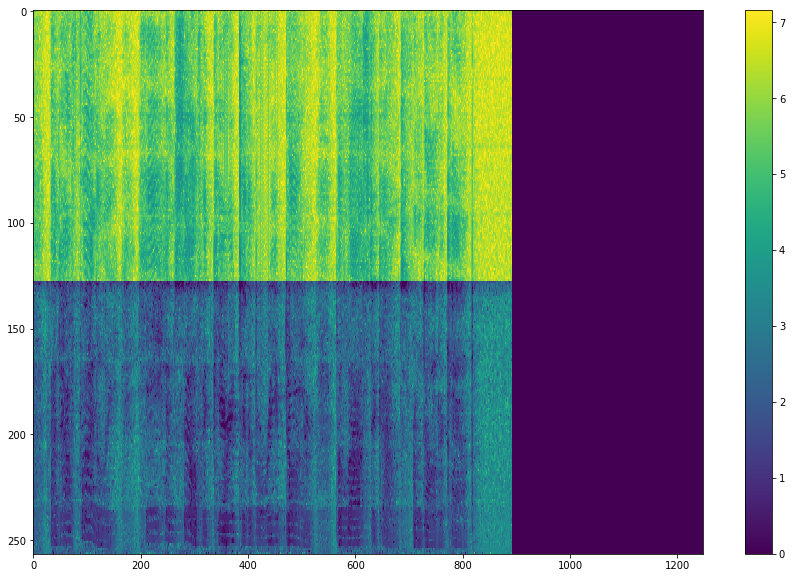

In [46]:
im = gt[0] * 0
im[:, :129] = image[0]
g  = gt[0]
plt.figure(figsize=(15,10))
plt.imshow(np.rot90(g - im), aspect='auto', vmin=0)
plt.colorbar()
plt.show()

In [43]:
import os
a = sio.read('./DAE-libri/9149.wav.gsm.wav')[1]
Audio(a, rate=16000)

In [37]:
dataset.files

['9149.wav',
 '16053.wav',
 '21949.wav',
 '15951.wav',
 '2051.wav',
 '25775.wav',
 '3502.wav',
 '24701.wav',
 '15422.wav',
 '13071.wav',
 '4223.wav',
 '13809.wav',
 '4689.wav',
 '2837.wav',
 '21541.wav',
 '6289.wav',
 '52.wav',
 '17211.wav',
 '28319.wav',
 '641.wav',
 '20610.wav',
 '24413.wav',
 '21845.wav',
 '8834.wav',
 '2056.wav',
 '8344.wav',
 '25812.wav',
 '20413.wav',
 '4114.wav',
 '7756.wav',
 '9809.wav',
 '5233.wav',
 '20763.wav',
 '27557.wav',
 '16101.wav',
 '4999.wav',
 '6614.wav',
 '23669.wav',
 '11969.wav',
 '27008.wav',
 '19587.wav',
 '12149.wav',
 '12170.wav',
 '25154.wav',
 '26310.wav',
 '24931.wav',
 '9899.wav',
 '7372.wav',
 '12576.wav',
 '21810.wav',
 '19291.wav',
 '20238.wav',
 '26936.wav',
 '22024.wav',
 '21578.wav',
 '21574.wav',
 '25197.wav',
 '13249.wav',
 '5732.wav',
 '10403.wav',
 '14974.wav',
 '10881.wav',
 '4463.wav',
 '27072.wav',
 '13498.wav',
 '10870.wav',
 '3693.wav',
 '18985.wav',
 '26408.wav',
 '27722.wav',
 '11101.wav',
 '2213.wav',
 '824.wav',
 '20361

# Conclusions

Definitely I had bad code for GSM processing - resaving using floats generated a lot of noise to the original signal... What was interesting is that the heavily distorted signal already was comprehensible to the network and meaningful high-band restoration was achieved. Saving the results as they are and going to the second objective. This experiment will be rerun with correct settings